<a href="https://colab.research.google.com/github/YuHsiu15/TMBAfile/blob/main/TMBAfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data acquisition & preprocessing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

params = {'legend.fontsize': 'x-large',
      'figure.figsize': (12, 6),
      'axes.labelsize': 'x-large',
      'axes.titlesize': 'x-large',
      'xtick.labelsize': 'x-large',
      'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

In [3]:
!pip install --upgrade pandas-datareader
!pip install ffn ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=9dc50fe2b2632e9c7e65eb2bf83f1a377f09c152764d48615202f407083477ba
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [4]:
import ffn
from ffn.utils import clean_ticker

target = "2330.tw"
name = clean_ticker(target)
asset = ffn.get(target, start = "2015-01-01")

asset

,2330tw
Date,
2015-01-05,109.558807
2015-01-06,104.846565
2015-01-07,105.239258
2015-01-08,108.380730
2015-01-09,105.239258
...,...
2022-09-02,485.000000
2022-09-05,486.000000
2022-09-06,489.000000


# Data visualization

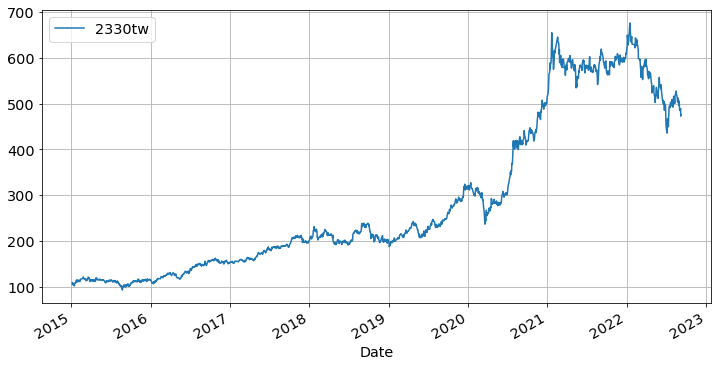

In [5]:
%matplotlib inline
asset.plot.line(grid = True, figsize = (12, 6))

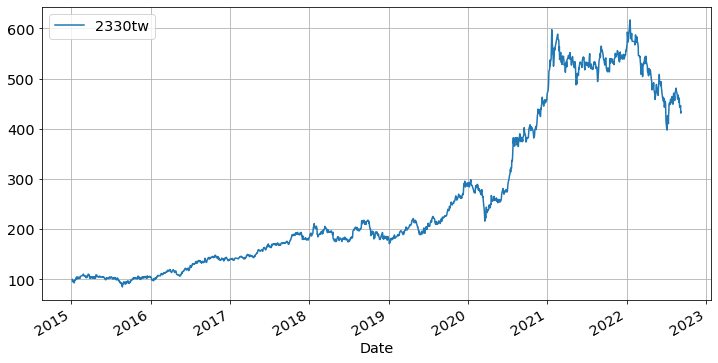

In [6]:
asset.rebase().plot.line(grid = True, figsize = (12, 6))

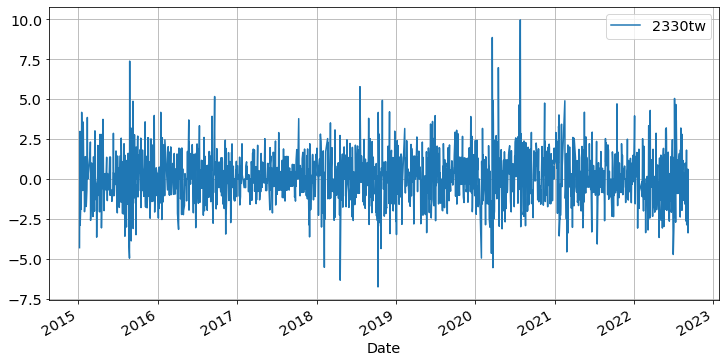

In [7]:
return_rates = asset.pct_change() * 100
return_rates.plot.line(grid = True, figsize = (12, 6))

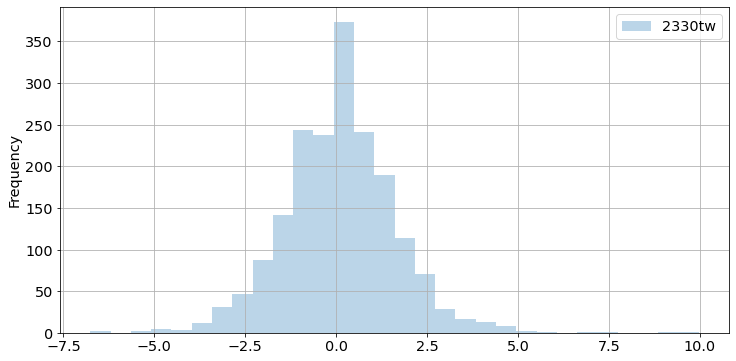

In [8]:
return_rates.plot.hist(bins = 30, alpha = 0.3, grid = True, figsize = (12, 6))

In [9]:
asset.calc_stats().display()

Stat                 2330tw
-------------------  ----------
Start                2015-01-05
End                  2022-09-08
Risk-free rate       0.00%

Total Return         333.56%
Daily Sharpe         0.93
Daily Sortino        1.65
CAGR                 21.06%
Max Drawdown         -35.57%
Calmar Ratio         0.59

MTD                  -5.94%
3m                   -12.21%
6m                   -14.75%
YTD                  -21.96%
1Y                   -21.75%
3Y (ann.)            24.96%
5Y (ann.)            20.15%
10Y (ann.)           -
Since Incep. (ann.)  21.06%

Daily Sharpe         0.93
Daily Sortino        1.65
Daily Mean (ann.)    22.74%
Daily Vol (ann.)     24.54%
Daily Skew           0.29
Daily Kurt           2.50
Best Day             9.97%
Worst Day            -6.76%

Monthly Sharpe       0.93
Monthly Sortino      2.03
Monthly Mean (ann.)  21.67%
Monthly Vol (ann.)   23.21%
Monthly Skew         1.19
Monthly Kurt         6.58
Best Month           35.94%
Worst Month          -14.54

# Strategy development

In [10]:
from ta.trend import macd_diff

asset["macd_diff"] = macd_diff(close = asset["2330tw"],  window_sign = 9, window_fast = 12, window_slow = 26)
asset["macd_diff"]

Date
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
2015-01-09         NaN
                ...   
2022-09-02   -3.690099
2022-09-05   -3.814641
2022-09-06   -3.507920
2022-09-07   -4.183419
2022-09-08   -4.217074
Name: macd_diff, Length: 1874, dtype: float64

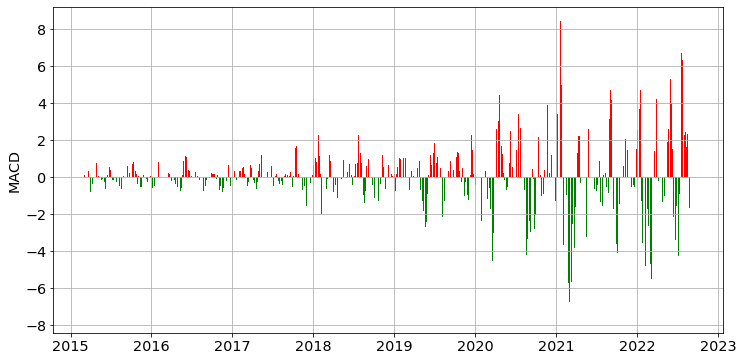

In [11]:
plt.figure(figsize = (12, 6))
plt.bar(asset.index[asset["macd_diff"] > 0], asset["macd_diff"][asset["macd_diff"] > 0], color = "r")
plt.bar(asset.index[asset["macd_diff"] <= 0], asset["macd_diff"][asset["macd_diff"] <= 0], color = "g")
plt.grid(True)
plt.ylabel("MACD")

plt.show()


In [12]:
buy_signal_mask = (asset["macd_diff"].shift(2) <= 0) & (asset["macd_diff"].shift(1) > 0)
buy_signal_mask

Date
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08    False
2015-01-09    False
              ...  
2022-09-02    False
2022-09-05    False
2022-09-06    False
2022-09-07    False
2022-09-08    False
Name: macd_diff, Length: 1874, dtype: bool

In [13]:
sell_signal_mask = (asset["macd_diff"].shift(2) >= 0) & (asset["macd_diff"].shift(1) < 0)
sell_signal_mask

Date
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08    False
2015-01-09    False
              ...  
2022-09-02    False
2022-09-05    False
2022-09-06    False
2022-09-07    False
2022-09-08    False
Name: macd_diff, Length: 1874, dtype: bool

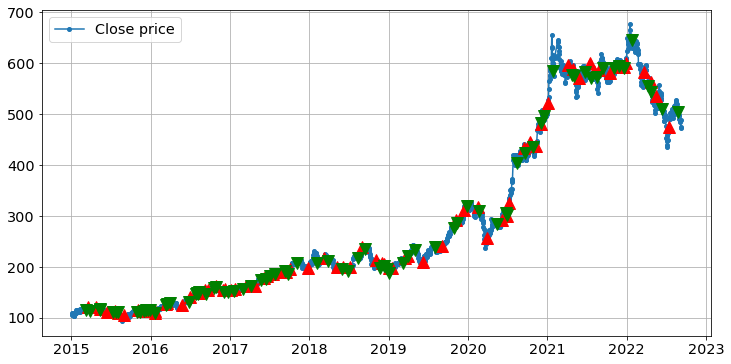

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.plot(asset[name], ".-", markersize = 8)
plt.plot(asset[name][buy_signal_mask], "r^", markersize = 12)
plt.plot(asset[name][sell_signal_mask], "gv", markersize = 12)
plt.grid(True)
plt.legend(["Close price"])

# Backtesting

只做多

In [15]:
position = False
asset["PV"] = 0.0
turnovers = 0

for i, t in enumerate(asset.index):
    
    if not position:
        
        payoff = 0
        asset["PV"].iloc[i] = asset["PV"].iloc[i - 1] + payoff
        
        if buy_signal_mask[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a long position.")
    else:
        
        payoff = asset[name].iloc[i] - asset[name].iloc[i - 1]
        asset["PV"].iloc[i] = asset["PV"].iloc[i - 1] + payoff
       
        if sell_signal_mask[t]:
            position = False
            print("<" * 5, "Close a long position.")
            print("{} -> {:.2f} -> {:.2f}".format(t, asset[name][t], asset["PV"][t]))

print("Number of turnovers:", turnovers)

>>>>> Create a long position.
<<<<< Close a long position.
2015-03-27 00:00:00 -> 111.91 -> -9.03
>>>>> Create a long position.
<<<<< Close a long position.
2015-05-11 00:00:00 -> 116.63 -> -12.17
>>>>> Create a long position.
<<<<< Close a long position.
2015-05-15 00:00:00 -> 115.06 -> -12.96
>>>>> Create a long position.
<<<<< Close a long position.
2015-07-10 00:00:00 -> 110.61 -> -13.87
>>>>> Create a long position.
<<<<< Close a long position.
2015-07-24 00:00:00 -> 111.02 -> -15.49
>>>>> Create a long position.
<<<<< Close a long position.
2015-08-04 00:00:00 -> 110.61 -> -13.87
>>>>> Create a long position.
<<<<< Close a long position.
2015-10-29 00:00:00 -> 110.61 -> -7.79
>>>>> Create a long position.
<<<<< Close a long position.
2015-11-11 00:00:00 -> 111.42 -> -11.84
>>>>> Create a long position.
<<<<< Close a long position.
2015-11-30 00:00:00 -> 112.64 -> -11.84
>>>>> Create a long position.
<<<<< Close a long position.
2015-12-10 00:00:00 -> 114.26 -> -13.06
>>>>> Create

In [16]:
asset["MDD (Ours)"] = (asset["PV"] - asset["PV"].cummax()).cummin()
dd_idx = asset["MDD (Ours)"].idxmin()
asset["Buy&Hold"] = asset[name].diff().cumsum()
asset["MDD (Buy&Hold)"] = (asset["Buy&Hold"] - asset["Buy&Hold"].cummax()).cummin()
dd_idx2 = asset["MDD (Buy&Hold)"].idxmin()

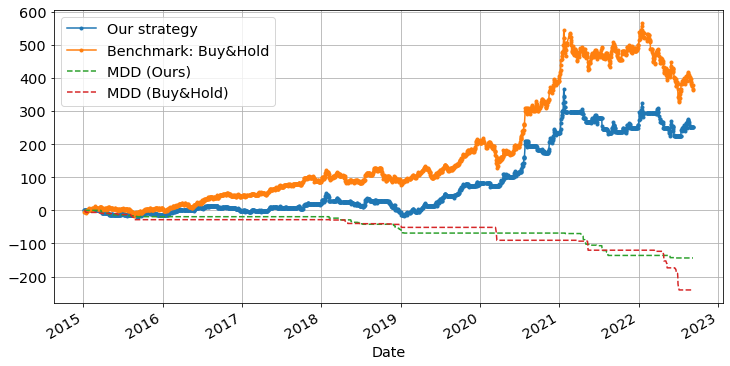

In [17]:
asset[["PV", "Buy&Hold"]].plot(style = ".-", grid = True, figsize = (12, 6))
ax = asset["MDD (Ours)"].plot(style = "--", grid = True)
ax = asset["MDD (Buy&Hold)"].plot(style = "--", grid = True)
ax.legend(["Our strategy", "Benchmark: Buy&Hold", "MDD (Ours)", "MDD (Buy&Hold)"])

只做空

In [18]:
position = False
asset["PV2"] = 0.0
turnovers = 0

for i, t in enumerate(asset.index):
    
    if not position:
        
        payoff = 0

        if sell_signal_mask[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a short position.")
    else:
        
        payoff = asset[name].iloc[i] - asset[name].iloc[i - 1]

        if buy_signal_mask[t]:
            position = False
            payoff = -payoff
            print("<" * 5, "Close a short position.")

        asset["PV2"].iloc[i] = asset["PV2"].iloc[i - 1] + payoff
        print("{} -> {:.2f} -> {:.2f}".format(t, asset[name][t], asset["PV2"][t]))
        
print("Number of turnovers:", turnovers)

>>>>> Create a short position.
2015-03-10 00:00:00 -> 113.09 -> -1.18
2015-03-11 00:00:00 -> 114.66 -> 0.39
2015-03-12 00:00:00 -> 116.23 -> 1.96
2015-03-13 00:00:00 -> 117.02 -> 2.75
2015-03-16 00:00:00 -> 114.66 -> 0.39
2015-03-17 00:00:00 -> 117.02 -> 2.75
2015-03-18 00:00:00 -> 120.55 -> 6.28
2015-03-19 00:00:00 -> 120.95 -> 6.68
<<<<< Close a short position.
2015-03-20 00:00:00 -> 120.95 -> 6.68
>>>>> Create a short position.
2015-03-30 00:00:00 -> 111.91 -> 0.00
2015-03-31 00:00:00 -> 114.27 -> 2.36
2015-04-01 00:00:00 -> 113.09 -> 1.18
2015-04-02 00:00:00 -> 115.45 -> 3.53
2015-04-07 00:00:00 -> 114.66 -> 2.75
2015-04-08 00:00:00 -> 112.31 -> 0.39
2015-04-09 00:00:00 -> 112.31 -> 0.39
2015-04-10 00:00:00 -> 115.45 -> 3.53
2015-04-13 00:00:00 -> 115.45 -> 3.53
2015-04-14 00:00:00 -> 113.09 -> 1.18
2015-04-15 00:00:00 -> 112.31 -> 0.39
2015-04-16 00:00:00 -> 115.45 -> 3.53
2015-04-17 00:00:00 -> 111.91 -> 0.00
2015-04-20 00:00:00 -> 112.31 -> 0.39
2015-04-21 00:00:00 -> 111.91 -> 

In [19]:
asset["MDD (Ours)"] = (asset["PV2"] - asset["PV2"].cummax()).cummin()
dd_idx = asset["MDD (Ours)"].idxmin()
asset["Sell&Hold"] = -asset["Buy&Hold"]
asset["MDD (Sell&Hold)"] = (asset["Sell&Hold"] - asset["Sell&Hold"].cummax()).cummin()
dd_idx2 = asset["MDD (Sell&Hold)"].idxmin()

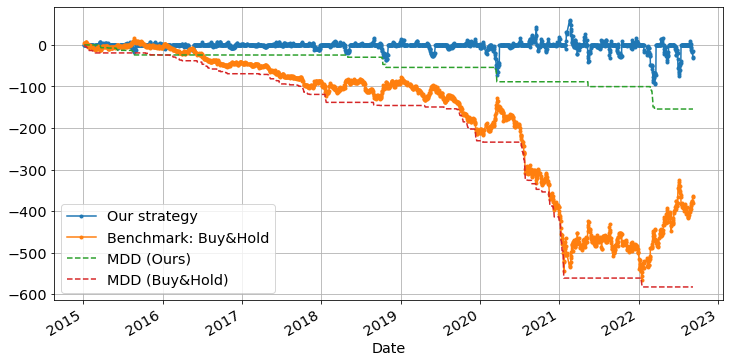

In [20]:
asset[["PV2", "Sell&Hold"]].plot(style = ".-", grid = True, figsize = (12, 6))
ax = asset["MDD (Ours)"].plot(style = "--", grid = True)
ax = asset["MDD (Sell&Hold)"].plot(style = "--", grid = True)
ax.legend(["Our strategy", "Benchmark: Buy&Hold", "MDD (Ours)", "MDD (Buy&Hold)"])

# 加入加權指數(^TWII)及均線作為篩選條件
當加權指數高於均線只做多,低於均線只做空

MA參數最佳化(20日, 25日, 30日)

train data: 2015-2019

test data: 2020-2022


In [21]:
TWII = ffn.get("^TWII", start = "2015-01-01")

TWII

,twii
Date,
2015-01-05,9274.076172
2015-01-06,9048.306641
2015-01-07,9080.055664
2015-01-08,9237.996094
2015-01-09,9215.545898
...,...
2022-09-02,14673.040039
2022-09-05,14661.099609
2022-09-06,14677.200195


In [22]:
TWII["SMA20"] = TWII["twii"].rolling(20).mean()
TWII["SMA25"] = TWII["twii"].rolling(25).mean()
TWII["SMA30"] = TWII["twii"].rolling(30).mean()

df_TWII = TWII.dropna()

In [23]:
#2015-7-10 TWII無資料
trainData_asset = asset[(asset.index >= '2015-03-02') & (asset.index <= '2019-12-31') & (asset.index != '2015-07-10')].copy()
testData_asset = asset[(asset.index >= '2020-1-1')].copy()

In [24]:
condition1 = df_TWII["twii"] >= df_TWII["SMA20"]
condition2 = df_TWII["twii"] >= df_TWII["SMA25"]
condition3 = df_TWII["twii"] >= df_TWII["SMA30"]

condition_list = ['condition1', 'condition2', 'condition3']
condition_array = pd.concat([condition1, condition2, condition3], axis = 1)
condition_array.columns = ['condition1', 'condition2', 'condition3']

In [25]:
for condition in condition_list:
  position = False
  trainData_asset[condition] = 0.0
  turnovers = 0
  for i, t in enumerate(trainData_asset.index):
    
    if not position:
        
        payoff = 0
        
        if buy_signal_mask[t] and condition_array[condition][t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a long position.")
            
        if sell_signal_mask[t] and not condition_array[condition][t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a short position.")
    else:
        
        payoff = trainData_asset[name].iloc[i] - trainData_asset[name].iloc[i - 1]
       
        if sell_signal_mask[t]:
            position = False
            print("<" * 5, "Close a long position.")
            
        if buy_signal_mask[t]:
            position = False
            payoff = -payoff
            print("<" * 5, "Close a short position.")
            
            
    trainData_asset[condition].iloc[i] = trainData_asset[condition].iloc[i - 1] + payoff
    print("{} -> {:.2f} -> {:.2f}".format(t, trainData_asset[name][t], trainData_asset[condition][t]))

  print("Number of turnovers", turnovers)

2015-03-02 00:00:00 -> 117.02 -> 0.00
2015-03-03 00:00:00 -> 118.20 -> 0.00
2015-03-04 00:00:00 -> 118.20 -> 0.00
2015-03-05 00:00:00 -> 117.81 -> 0.00
2015-03-06 00:00:00 -> 117.02 -> 0.00
2015-03-09 00:00:00 -> 114.27 -> 0.00
2015-03-10 00:00:00 -> 113.09 -> 0.00
2015-03-11 00:00:00 -> 114.66 -> 0.00
2015-03-12 00:00:00 -> 116.23 -> 0.00
2015-03-13 00:00:00 -> 117.02 -> 0.00
2015-03-16 00:00:00 -> 114.66 -> 0.00
2015-03-17 00:00:00 -> 117.02 -> 0.00
2015-03-18 00:00:00 -> 120.55 -> 0.00
2015-03-19 00:00:00 -> 120.95 -> 0.00
>>>>> Create a long position.
2015-03-20 00:00:00 -> 120.95 -> 0.00
2015-03-23 00:00:00 -> 120.55 -> -0.39
2015-03-24 00:00:00 -> 118.98 -> -1.96
2015-03-25 00:00:00 -> 118.59 -> -2.36
2015-03-26 00:00:00 -> 114.27 -> -6.68
<<<<< Close a long position.
2015-03-27 00:00:00 -> 111.91 -> -9.03
2015-03-30 00:00:00 -> 111.91 -> -9.03
2015-03-31 00:00:00 -> 114.27 -> -9.03
2015-04-01 00:00:00 -> 113.09 -> -9.03
2015-04-02 00:00:00 -> 115.45 -> -9.03
2015-04-07 00:00:00 

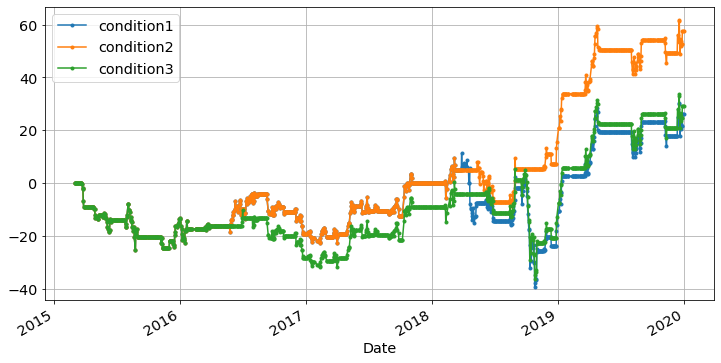

In [26]:
trainData_asset[["condition1", "condition2", "condition3"]].plot(style = ".-", grid = True, figsize = (12, 6))

In [27]:
Total_asset = pd.concat([trainData_asset, testData_asset])
Total_asset

,2330tw,macd_diff,PV,MDD (Ours),Buy&Hold,MDD (Buy&Hold),PV2,Sell&Hold,MDD (Sell&Hold),condition1,condition2,condition3
Date,,,,,,,,,,,,
2015-03-02,117.019783,0.366675,0.000000,0.000000,7.460976,-6.282944,0.0,-7.460976,-19.241501,0.0,0.0,0.0
2015-03-03,118.197815,0.286115,0.000000,0.000000,8.639008,-6.282944,0.0,-8.639008,-19.241501,0.0,0.0,0.0
2015-03-04,118.197815,0.202694,0.000000,0.000000,8.639008,-6.282944,0.0,-8.639008,-19.241501,0.0,0.0,0.0
2015-03-05,117.805153,0.096332,0.000000,0.000000,8.246346,-6.282944,0.0,-8.246346,-19.241501,0.0,0.0,0.0
2015-03-06,117.019783,-0.044115,0.000000,0.000000,7.460976,-6.282944,0.0,-7.460976,-19.241501,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02,485.000000,-3.690099,251.893967,-154.325928,375.441193,-240.462097,-18.0,-375.441193,-582.772614,NaN,NaN,NaN
2022-09-05,486.000000,-3.814641,251.893967,-154.325928,376.441193,-240.462097,-17.0,-376.441193,-582.772614,NaN,NaN,NaN
2022-09-06,489.000000,-3.507920,251.893967,-154.325928,379.441193,-240.462097,-14.0,-379.441193,-582.772614,NaN,NaN,NaN


In [28]:
#選用係數25日

position = False
Total_asset["condition2"] = 0.0
turnovers = 0

for i, t in enumerate(Total_asset.index):
    
    if not position:
        
        payoff = 0
        
        if buy_signal_mask[t] and condition2[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a long position.")
            
        if sell_signal_mask[t] and not condition2[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a short position.")
    else:
        
        payoff = Total_asset[name].iloc[i] - Total_asset[name].iloc[i - 1]
       
        if sell_signal_mask[t]:
            position = False
            print("<" * 5, "Close a long position.")
            
        if buy_signal_mask[t]:
            position = False
            payoff = -payoff
            print("<" * 5, "Close a short position.")
            
            
    Total_asset["condition2"].iloc[i] = Total_asset["condition2"].iloc[i - 1] + payoff
    print("{} -> {:.2f} -> {:.2f}".format(t, Total_asset[name][t], Total_asset["condition2"][t]))

print("Number of turnovers", turnovers)

2015-03-02 00:00:00 -> 117.02 -> 0.00
2015-03-03 00:00:00 -> 118.20 -> 0.00
2015-03-04 00:00:00 -> 118.20 -> 0.00
2015-03-05 00:00:00 -> 117.81 -> 0.00
2015-03-06 00:00:00 -> 117.02 -> 0.00
2015-03-09 00:00:00 -> 114.27 -> 0.00
2015-03-10 00:00:00 -> 113.09 -> 0.00
2015-03-11 00:00:00 -> 114.66 -> 0.00
2015-03-12 00:00:00 -> 116.23 -> 0.00
2015-03-13 00:00:00 -> 117.02 -> 0.00
2015-03-16 00:00:00 -> 114.66 -> 0.00
2015-03-17 00:00:00 -> 117.02 -> 0.00
2015-03-18 00:00:00 -> 120.55 -> 0.00
2015-03-19 00:00:00 -> 120.95 -> 0.00
>>>>> Create a long position.
2015-03-20 00:00:00 -> 120.95 -> 0.00
2015-03-23 00:00:00 -> 120.55 -> -0.39
2015-03-24 00:00:00 -> 118.98 -> -1.96
2015-03-25 00:00:00 -> 118.59 -> -2.36
2015-03-26 00:00:00 -> 114.27 -> -6.68
<<<<< Close a long position.
2015-03-27 00:00:00 -> 111.91 -> -9.03
2015-03-30 00:00:00 -> 111.91 -> -9.03
2015-03-31 00:00:00 -> 114.27 -> -9.03
2015-04-01 00:00:00 -> 113.09 -> -9.03
2015-04-02 00:00:00 -> 115.45 -> -9.03
2015-04-07 00:00:00 

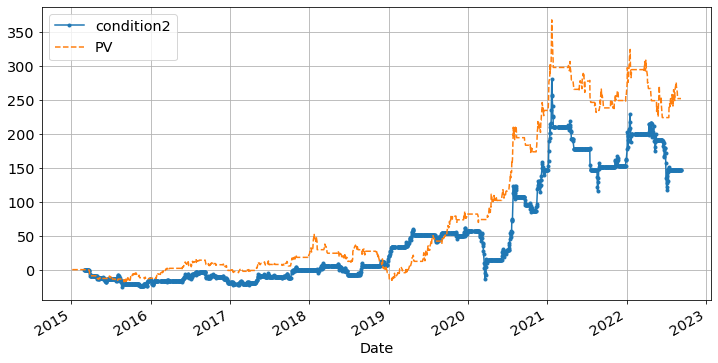

In [29]:
Total_asset[["condition2"]].plot(style = ".-", grid = True, figsize = (12, 6))
ax = asset["PV"].plot(style = "--", grid = True)
ax.legend(["condition2", "PV"])

In [30]:
#選用係數25日且只做多

position = False
Total_asset["condition2"] = 0.0
turnovers = 0

for i, t in enumerate(Total_asset.index):
    
    if not position:
        
        payoff = 0
        
        if buy_signal_mask[t] and condition2[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a long position.")
            
    else:
        
        payoff = Total_asset[name].iloc[i] - Total_asset[name].iloc[i - 1]
       
        if sell_signal_mask[t]:
            position = False
            print("<" * 5, "Close a long position.")
            
    Total_asset["condition2"].iloc[i] = Total_asset["condition2"].iloc[i - 1] + payoff
    print("{} -> {:.2f} -> {:.2f}".format(t, Total_asset[name][t], Total_asset["condition2"][t]))

print("Number of turnovers", turnovers)

2015-03-02 00:00:00 -> 117.02 -> 0.00
2015-03-03 00:00:00 -> 118.20 -> 0.00
2015-03-04 00:00:00 -> 118.20 -> 0.00
2015-03-05 00:00:00 -> 117.81 -> 0.00
2015-03-06 00:00:00 -> 117.02 -> 0.00
2015-03-09 00:00:00 -> 114.27 -> 0.00
2015-03-10 00:00:00 -> 113.09 -> 0.00
2015-03-11 00:00:00 -> 114.66 -> 0.00
2015-03-12 00:00:00 -> 116.23 -> 0.00
2015-03-13 00:00:00 -> 117.02 -> 0.00
2015-03-16 00:00:00 -> 114.66 -> 0.00
2015-03-17 00:00:00 -> 117.02 -> 0.00
2015-03-18 00:00:00 -> 120.55 -> 0.00
2015-03-19 00:00:00 -> 120.95 -> 0.00
>>>>> Create a long position.
2015-03-20 00:00:00 -> 120.95 -> 0.00
2015-03-23 00:00:00 -> 120.55 -> -0.39
2015-03-24 00:00:00 -> 118.98 -> -1.96
2015-03-25 00:00:00 -> 118.59 -> -2.36
2015-03-26 00:00:00 -> 114.27 -> -6.68
<<<<< Close a long position.
2015-03-27 00:00:00 -> 111.91 -> -9.03
2015-03-30 00:00:00 -> 111.91 -> -9.03
2015-03-31 00:00:00 -> 114.27 -> -9.03
2015-04-01 00:00:00 -> 113.09 -> -9.03
2015-04-02 00:00:00 -> 115.45 -> -9.03
2015-04-07 00:00:00 

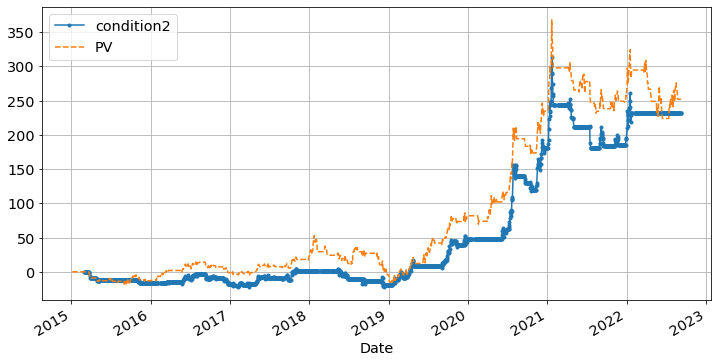

In [31]:
Total_asset[["condition2"]].plot(style = ".-", grid = True, figsize = (12, 6))
ax = asset["PV"].plot(style = "--", grid = True)
ax.legend(["condition2", "PV"])

# 結論
單一使用MACD指標且只做多的報酬最好,但仍低於一開始就持續持有的報酬